In [1]:
import sys
sys.path.append("../")  # go to parent directory

from src.utils import read_xlsx, create_logging, split_data, calculate_metrics

from src.modeling_manager.data_transformer import DataTransformer
from src.modeling_manager.modeling import select_model, train_best_model, evaluate_model, save_model
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve

# classification algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from src.modeling_manager.model_optimizer import Optimizer

In [2]:
create_logging()

In [3]:
# read the data 
path_to_train_data = "../data/train_file.xlsx"
df = read_xlsx(path_to_train_data)
df.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,previous,poutcome,y
0,49,blue-collar,married,basic.9y,unknown,no,no,cellular,nov,wed,227,4,0,nonexistent,no
1,37,entrepreneur,married,university.degree,no,no,no,telephone,nov,wed,202,2,1,failure,no
2,78,retired,married,basic.4y,no,no,no,cellular,jul,mon,1148,1,0,nonexistent,yes
3,36,admin.,married,university.degree,no,yes,no,telephone,may,mon,120,2,0,nonexistent,no
4,59,retired,divorced,university.degree,no,no,no,cellular,jun,tue,368,2,0,nonexistent,no


#### Data preprocessing

**Removing *features* from the dataset:**
* **duration**:
* This feature is highly correlated with the target variable "y", indicating that longer contact times are associated with a higher probability of subscribing to a fixed-term deposit. However, the duration of a contact is only known after the contact has been completed and the customer has made their decision. For predictive inference in production, where predictions need to be made before the contact occurs, including "duration" as a feature is impractical. Therefore, this feature should be excluded from the training data to ensure the model can be effectively used for real-time prediction.
  
**Dealing with unknown categories:** 
* Categories labeled as "unknown" in features such as "job", "education", "default", "housing", and "loan" will be removed. These categories do not provide significant predictive value and their removal helps in cleaning the dataset.

**Combining basic education categories:**
* To simplify the dataset and improve model performance, all basic education categories ("basic.4y", "basic.6y", "basic.9y") are combined into a single, more general category "education.basic". This reduces the complexity of the education feature and helps the model generalize better by treating all levels of basic education as equivalent.

**Binning age:** 
* Given the wide distribution of ages in the dataset, this category will be split into four quantile-based bins. This approach groups ages into four equally sized bins, helping to normalize the distribution and potentially improve model performance by reducing the effect of outliers.

**Feature Encoding**:
* _**Ordinal features**_:
  * **age**: Encoded into quantile-based bins and then transformed using OrdinalEncoder.
  * **education**: Combined into "education.basic" and encoded using OrdinalEncoder.
  * **month**: Encoded using OrdinalEncoder to reflect the natural order of months.

* _**Categorical features**_:
    * **job**: Encoded using OneHotEncoder to create binary columns for each job category.
    * **default**, **loan**, **housing**, and for training data **y**: Encoded using binary mapping (e.g., "yes" = 1, "no" = 0).

In [4]:
# initialize Preprocessor
data_transformer = DataTransformer(df)

# preprocess some data
df = data_transformer.clean_and_transform()
df

,bins_age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,previous,poutcome,y
1,young_adult,entrepreneur,married,university.degree,0,0,0,1,nov,wed,2,1,failure,0
2,old_age,retired,married,education.basic,0,0,0,0,jul,mon,1,0,nonexistent,1
3,young_adult,admin.,married,university.degree,0,1,0,1,may,mon,2,0,nonexistent,0
4,middle_aged,retired,divorced,university.degree,0,0,0,0,jun,tue,2,0,nonexistent,0
5,young,admin.,single,university.degree,0,0,0,0,aug,wed,2,0,nonexistent,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32903,middle_aged,technician,married,education.basic,0,0,0,1,may,fri,5,0,nonexistent,0
32905,young,management,single,university.degree,0,0,0,0,nov,thu,5,1,failure,0
32906,young_adult,blue-collar,married,high.school,0,1,0,1,jun,mon,3,0,nonexistent,0
32907,young_adult,technician,married,professional.course,0,1,1,0,aug,mon,1,0,nonexistent,0


### Model selection

In [5]:
# define the models
models = {
    'LogisticRegression': LogisticRegression(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'SVC': SVC(),
    'KNN': KNeighborsClassifier()
}

In [6]:
# Split the data
X_train, X_test, y_train, y_test = split_data(df, target='y')

#### Step 1: Transform data and evaluate models with cross-validation

In [7]:
eval_results = select_model(X_train, y_train, data_transformer, models)
eval_results

{'LogisticRegression': {'fit_time_mean': 0.13977770805358886,
  'accuracy_mean': 0.6804226608535768,
  'f1_mean': 0.3360552797448113,
  'roc_auc_mean': 0.7127669404300621},
 'DecisionTreeClassifier': {'fit_time_mean': 0.16210031509399414,
  'accuracy_mean': 0.8084175583688944,
  'f1_mean': 0.2902942164434993,
  'roc_auc_mean': 0.5909539214626855},
 'RandomForestClassifier': {'fit_time_mean': 2.0545517921447756,
  'accuracy_mean': 0.8599197367954978,
  'f1_mean': 0.329156663009158,
  'roc_auc_mean': 0.7138162136164714},
 'GradientBoostingClassifier': {'fit_time_mean': 3.3498823165893556,
  'accuracy_mean': 0.874891115721679,
  'f1_mean': 0.37977494283542346,
  'roc_auc_mean': 0.7535767690925346},
 'SVC': {'fit_time_mean': 22.040139722824097,
  'accuracy_mean': 0.7510350879559101,
  'f1_mean': 0.3630356141037584,
  'roc_auc_mean': 0.7102222692892444},
 'KNN': {'fit_time_mean': 0.06374573707580566,
  'accuracy_mean': 0.7115638386371084,
  'f1_mean': 0.3155700822770773,
  'roc_auc_mean': 0

In [8]:
# best model based on accuracy mean score
best_model_name = max(eval_results, key=lambda model: eval_results[model]["f1_mean"])
print(f"Best performed model: '{best_model_name}'") 

Best performed model: 'GradientBoostingClassifier'


#### Analysis and Comparison of Model Performance
* **Logistic Regression** has a moderate accuracy and ROC AUC score, with a relatively low F1 score, indicating potential issues with handling imbalanced classes.
* **Decision Tree** shows high accuracy but lower F1 and ROC AUC scores, suggesting overfitting to the training data and poor generalization.
* **Random Forest** provides a good balance between accuracy, F1, and ROC AUC scores, with reasonable fit time. It appears to handle the data well.
* **Gradient Boosting** has the highest accuracy and ROC AUC scores, along with the highest F1 score. The fit time is longer, but the model shows strong performance overall.
* **SVC** has good performance in terms of F1 score and ROC AUC but has a lower accuracy and significantly longer fit time, making it less efficient.
* **KNN** shows moderate performance across all metrics with a very short fit time. It might be suitable for quick evaluations, but not for high-performance requirements.

So **Gradient Boosting Classifier** and **Random Forest Classifier** are the best performing models.

#### Other approaches to find the best model:

1. **Hyperparameter Tuning**:
    * Grid Search
    * Random Search
    * Bayesian Optimization
    * _Optuna_ - advanced hyperparameter optimization framework that uses Bayesian optimization to efficiently search the hyperparameter space, supports pruning of unpromising trials and enables more flexible and complex parameter search.
2. **Model evaluation based on its robustness and stability**
    * **Robustness testing**: evaluation of the model performance under different scenarios (e.g., noisy data or outliers)
    * **Stability testing**: evaluation of the consistency of model performance across different data splits or perturbations in the dataset.
4. **Ensemble Methods**: bagging, boosting, stacking
5. **Use of business (domain-specific) metrics**: conversion rate or customer churn rate
6. **Model evaluation based on model efficiency**: training time, inference time, resource usage

#### Step 2: Train the model with the best score

In [9]:
%%time
model_pipeline = train_best_model(models,
                best_model_name,
                data_transformer,
                X_train,
                y_train)

CPU times: user 4.39 s, sys: 0 ns, total: 4.39 s
Wall time: 4.21 s


#### Step 3: Evaluate the model on the test data

In [10]:
y_pred = evaluate_model(model_pipeline, X_test, y_test)
metrics = calculate_metrics(y_test, y_pred)
metrics

2024-06-05 19:49:47,177 - src.modeling_manager.modeling - INFO - 
              precision    recall  f1-score   support

           0       0.90      0.97      0.93      3995
           1       0.56      0.29      0.38       598

    accuracy                           0.88      4593
   macro avg       0.73      0.63      0.66      4593
weighted avg       0.86      0.88      0.86      4593



{'accuracy': 0.8782930546483779,
 'balanced_accuracy_score': 0.6271669017710265,
 'precision': 0.8568128591897192,
 'recall': 0.8782930546483779,
 'f1_score': 0.8607002963008074}

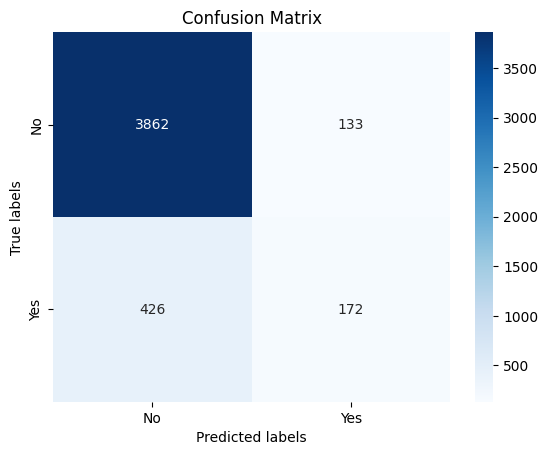

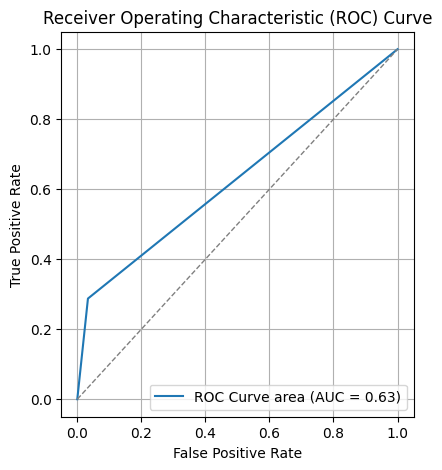

In [11]:
def show_confusion_mtx(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()


def show_roc_curve(y_true, y_pred):
    # Generate ROC curve
    false_positive_rate, true_positive_rate, _ = roc_curve(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_pred)

    # Plot ROC curve
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(false_positive_rate, true_positive_rate, label=f'ROC Curve area (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid()

def plot_precision_recall_curve(y_true, y_probas, model_name):
    precision, recall, _ = precision_recall_curve(y_true, y_probas)
    plt.plot(recall, precision, marker='.', label=best_model_name)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid()

    
show_confusion_mtx(y_test, y_pred)
show_roc_curve(y_test, y_pred)

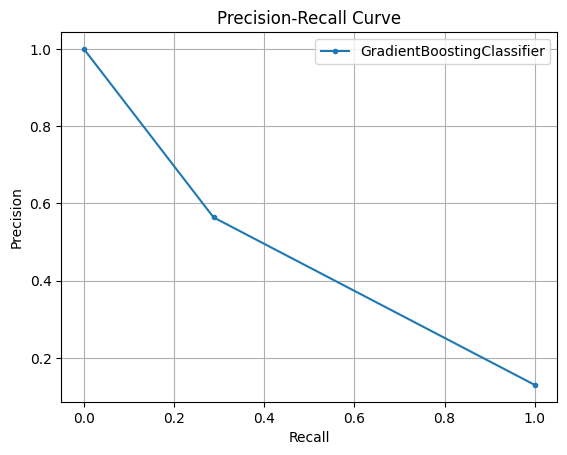

In [12]:
plot_precision_recall_curve(y_test, y_pred, best_model_name)

#### Step 4: Persist final model

In [13]:
save_model(model_pipeline)

2024-06-05 19:49:47,590 - src.modeling_manager.modeling - INFO - Final model saved to /home/nataliia/Workspaces/edu_private/user_subscription_prediction/model/trained_model_pipeline.pkl


#### Most relevant metric for evaluating a model's performance in a classification task:
1. **F1 Score** balances precision and recall, providing a single measure of performance that accounts for both false positives and false negatives.
2. **ROC AUC** provides a measure of how well the model distinguishes between classes across all thresholds. It is especially useful for imbalanced datasets as it is insensitive to class distribution.
3. **Precision-Recall Curve** focuses on the performance with respect to the positive class, providing a clear picture of how precision and recall trade off against each other.

#### *Optional Step: Hyperparameter tuning with Optuna
_Hyperparameter tuning can take more than 15 minutes depending on the number of trials_

In [14]:
# define the models again so that they can be initialized with parameters
models = {
    'LogisticRegression': LogisticRegression,
    'DecisionTreeClassifier': DecisionTreeClassifier,
    'RandomForestClassifier': RandomForestClassifier,
    'GradientBoostingClassifier': GradientBoostingClassifier,
    'SVC': SVC,
    'KNN': KNeighborsClassifier
}

# predifine a set of hyperparameters for the models
models_params = {
    "LogisticRegression":  {
        'C': [0.01, 0.1], # Regularization parameter, controlling the trade-off between maximizing the margin and minimizing classification error
        'solver': ["liblinear", "newton-cholesky"],
        'random_state': 42
    },
    "DecisionTreeClassifier": {
        'splitter': ["best", "random"],
        'max_depth':  [1, 4],
        'class_weight': [None, "balanced"],
        'random_state': 42
    },
    "RandomForestClassifier": {
        'n_estimators': [100, 500],
        'max_depth': [1, 4],
        'random_state': 42
    },
    "GradientBoostingClassifier": {
        'learning_rate': [0.01, 0.1, 0.2],
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 6, 9],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'subsample': [0.8, 0.9, 1.0],
        'random_state': 42
    },
    "SVC": {
        'C': [0.1, 1.5],
        'gamma': ["scale", "auto"],
        'kernel': ["linear", "poly", "rbf"],
        'random_state': 42
    },
    "KNN": {
        'n_neighbors': [2, 19],
        'weights': ['uniform', 'distance'],
        'metric': ['l2', 'manhattan', 'cosine']
    }
}

In [15]:
%%time
optimizer = Optimizer(best_model_name, models, models_params, n_trials=150)
tuned_model_pipeline = optimizer.hyperparameter_tuning(data_transformer, X_train, y_train)

# you can observe the optimization process starting optuna dashboard from notebooks/ directory using CLI:
# optuna-dashboard sqlite:///db.sqlite3

2024-06-05 19:49:47,610 - src.modeling_manager.model_optimizer - INFO - Initialized Optimizer with model: GradientBoostingClassifier
[I 2024-06-05 19:49:48,018] A new study created in RDB with name: no-name-bf79e0f6-9518-4107-878f-4b4b01c1bf23
[I 2024-06-05 19:50:20,821] Trial 0 finished with value: 0.2968908783628552 and parameters: {'learning_rate': 0.19973234827533445, 'n_estimators': 299, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 4, 'subsample': 0.9164198665135564}. Best is trial 0 with value: 0.2968908783628552.
[I 2024-06-05 19:50:40,495] Trial 1 finished with value: 0.32268030805346354 and parameters: {'learning_rate': 0.18112713322544352, 'n_estimators': 238, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 2, 'subsample': 0.9180426100137488}. Best is trial 1 with value: 0.32268030805346354.
[I 2024-06-05 19:50:49,460] Trial 2 finished with value: 0.4003797810380192 and parameters: {'learning_rate': 0.016744535999978296, 'n_estimators': 148, 'max_de

CPU times: user 38.3 s, sys: 4.8 s, total: 43.1 s
Wall time: 22min 21s


In [16]:
# evaluate the tuned model
y_pred = evaluate_model(tuned_model_pipeline, X_test, y_test)
metrics = calculate_metrics(y_test, y_pred)
metrics

2024-06-05 20:12:09,215 - src.modeling_manager.modeling - INFO - 
              precision    recall  f1-score   support

           0       0.91      0.94      0.92      3995
           1       0.48      0.37      0.42       598

    accuracy                           0.87      4593
   macro avg       0.70      0.66      0.67      4593
weighted avg       0.85      0.87      0.86      4593



{'accuracy': 0.8667537557152188,
 'balanced_accuracy_score': 0.6575037358571123,
 'precision': 0.8541807426825692,
 'recall': 0.8667537557152188,
 'f1_score': 0.8593209147732731}

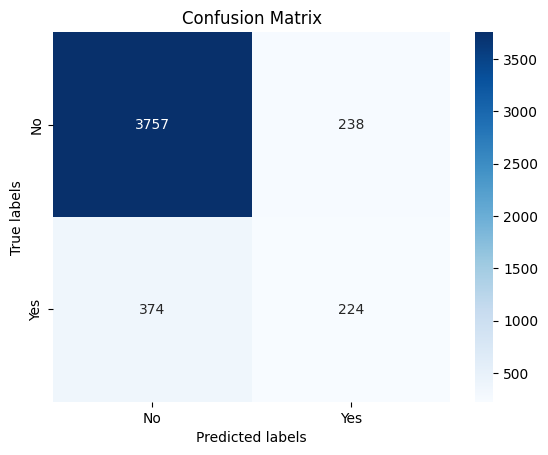

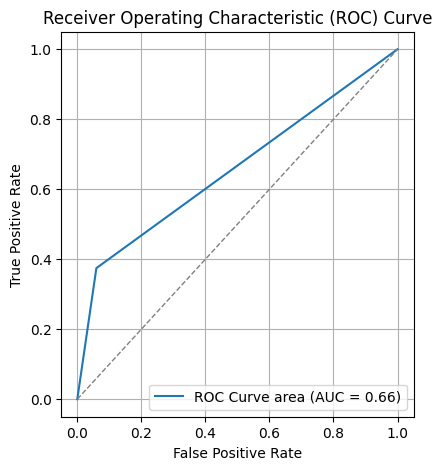

In [17]:
show_confusion_mtx(y_test, y_pred)
show_roc_curve(y_test, y_pred)

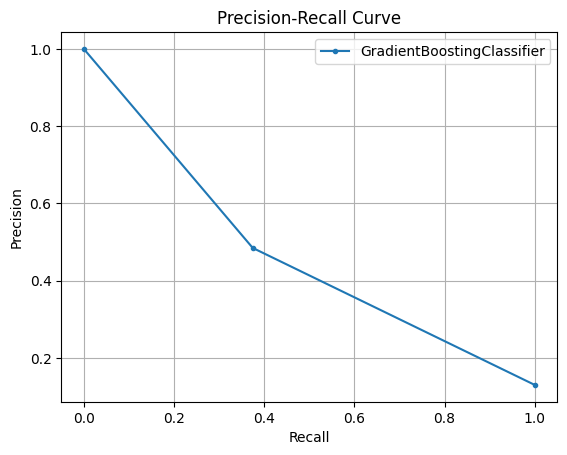

In [18]:
plot_precision_recall_curve(y_test, y_pred, best_model_name)

In [19]:
# persist tuned model
save_model(tuned_model_pipeline, file_name="trained_model_pipeline_tuned.pkl")

2024-06-05 20:12:09,754 - src.modeling_manager.modeling - INFO - Final model saved to /home/nataliia/Workspaces/edu_private/user_subscription_prediction/model/trained_model_pipeline_tuned.pkl
